Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0713
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0052
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0020
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - lo

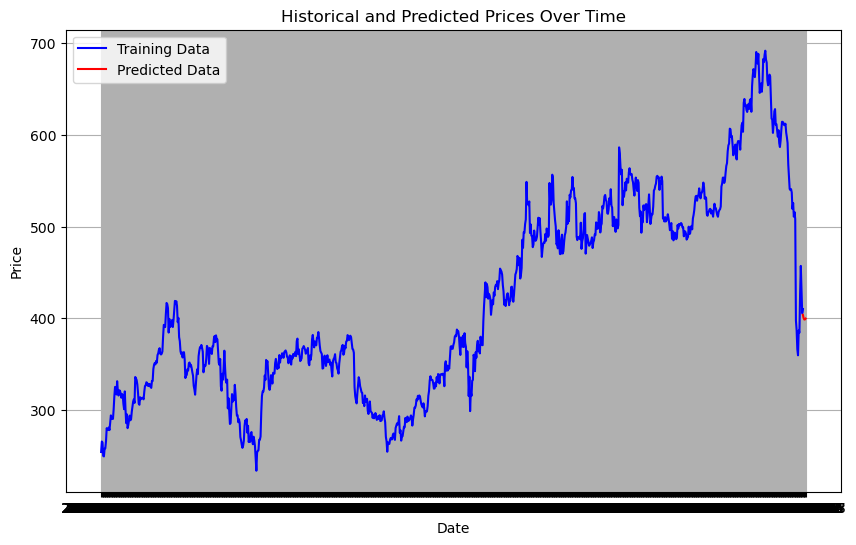

<Figure size 800x600 with 0 Axes>

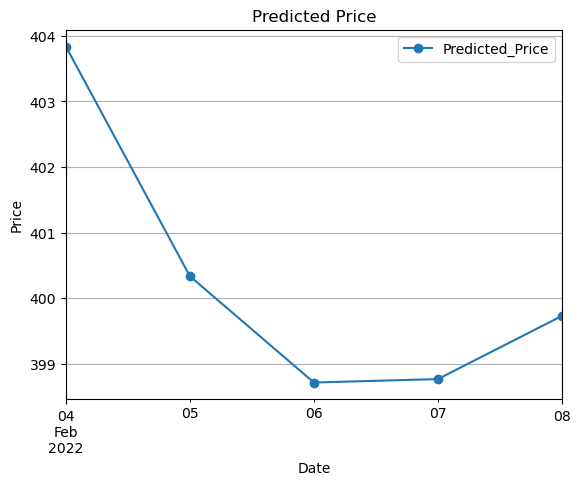

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

stock_data = pd.read_csv('C:/Users/TAWFEEQ/Desktop/dataset.csv')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

window_size = 10

def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, window_size)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

input_shape = (window_size, 1)

inputs = Input(shape=input_shape)

x = LSTM(units=50, return_sequences=True)(inputs)
x = LSTM(units=50, return_sequences=False)(x)
x = Dense(units=25)(x)
outputs = Dense(units=1)(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32)

mse = model.evaluate(X_test, y_test)
print("Mean Squared Error:", mse)

future_dates = pd.date_range(start=stock_data['Date'].iloc[-1], periods=5)
future_features = scaled_data[-window_size:].reshape(1, window_size, 1)  
future_predictions = []

for _ in range(5):
    future_price = model.predict(future_features)
    future_predictions.append(future_price[0][0])
    future_features = np.roll(future_features, -1, axis=1) 
    future_features[0, -1] = future_price  

predicted_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

future_dates = pd.date_range(start=stock_data['Date'].iloc[-1], periods=5)
future_predictions_df = pd.DataFrame({'Date': future_dates, 'Predicted_Price': predicted_prices.flatten()})
print(future_predictions_df)

plt.figure(figsize=(10, 6))

plt.plot(stock_data['Date'], scaler.inverse_transform(scaled_data), label='Training Data', color='blue')

plt.plot(future_dates.strftime('%Y-%m-%d'), predicted_prices, label='Predicted Data', color='red')

plt.title('Historical and Predicted Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

df = pd.DataFrame(future_predictions_df)

plt.figure(figsize=(8, 6))
df.plot(x='Date', y='Predicted_Price', kind='line', marker='o')
plt.title('Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()